#  Big Mart Sales Prediction

## LIBRARIES AND SETTINGS

In [1]:
import math
import datetime
import pickle
import warnings
import random

import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt
import xgboost                 as xgb

from boruta                    import BorutaPy
from sklearn.metrics           import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## FUNCTIONS

In [3]:
# configure the axes of the chart
def axis_settings(x_label, y_label = ' ', fontsize = 12, x_rotation = 0, y_rotation = 0):
    plt.xlabel(x_label, fontsize = fontsize)
    plt.ylabel(y_label, fontsize = fontsize)
    plt.xticks(fontsize = fontsize, rotation = x_rotation)
    plt.yticks(fontsize = fontsize, rotation = y_rotation)
    
    
# model errors
def ml_error(model_name, y_real, y_prediction):
    mae  = round(mean_absolute_error(y_real, y_prediction), 4)
    mape = round(mean_absolute_percentage_error(y_real, y_prediction), 4)
    rmse = round(mean_squared_error(y_real, y_prediction, squared = False), 4)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE':        mae,
                         'MAPE':       mape,
                         'RMSE':       rmse }, index = [0])


# model errors from cross validation
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    # lists
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print(f'\nKFold Number: {k}')
                  
        # start and end date for validation
        validation_start_date = x_training['Date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['Date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['Date'] < validation_start_date]
        validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]
                  
        # training and validation dataset
        # training
        xtraining = training.drop(['Date', 'Sales'], axis = 1)
        ytraining = training['Sales']
                  
        # validation
        xvalidation = validation.drop(['Date', 'Sales'], axis = 1)
        yvalidation = validation['Sales']
                  
        # model
        m = model.fit(xtraining, ytraining)
                  
        # prediction
        yhat = m.predict(xvalidation)
                  
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
                  
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
                  
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 4).astype(str) + ' +/- ' + np.round(np.std(mae_list), 4).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 4).astype(str) + ' +/- ' + np.round(np.std(mape_list), 4).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 4).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 4).astype(str)}, index = [0])


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

## 1. DATA LOADING

The data can be found on the [Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales) website.

In [4]:
# read csv files
df_sales = pd.read_csv('data/train.csv', low_memory = False)
df_store = pd.read_csv('data/store.csv', low_memory = False)

# merge
df = pd.merge(df_sales, df_store, how = 'left', on = 'Store')

## 2. DATA DESCRIPTION

In [5]:
# copy
df1 = df.copy()

### 2.1. Basic informations of the data

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

**Observations:**
- Some columns have NA values, so it's necessary deal with this;
- The type of attribute `date` is `object`, so it's necessary change do `datetime`.

### 2.2. Basic statistics

In [ ]:
# select specific types of data
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

#### 2.2.1. Numerical attributes

In [ ]:
# central tendency: mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,CompetitionDistance,20.0,75860.0,75840.0,5430.085652,NaN,7715.319898,2.928534,13.000022
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,7.222866,NaN,3.211830,-0.169862,-1.248357
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2008.690228,NaN,5.992640,-7.539515,121.934675


#### 2.2.2. Categorical attributes

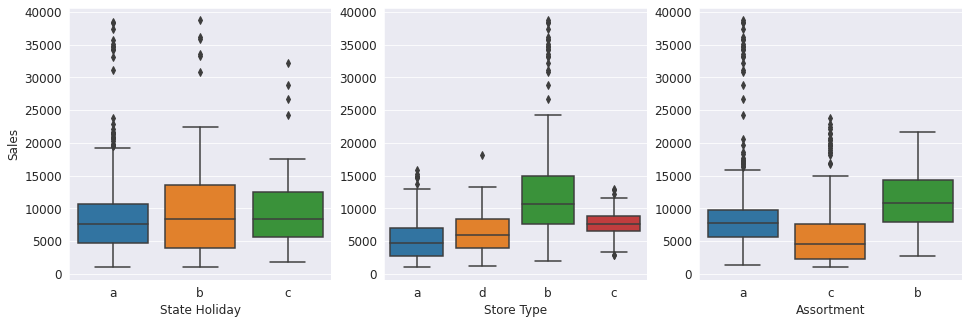

In [ ]:
# excludes the days that stores are closed and have not sold anything
aux = df1[(df1['StateHoliday'] != '0') & (df1['Sales'] > 0)]

plt.figure(figsize = (16, 5))

# graphic 1: State Holiday by sales
plt.subplot(1, 3, 1)
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = aux)
axis_settings('State Holiday', 'Sales')

# graphic 2: StoreType by sales
plt.subplot(1, 3, 2)
sns.boxplot(x = 'StoreType', y = 'Sales', data = aux)
axis_settings('Store Type')

# graphic 3: Assortment by sales
plt.subplot(1, 3, 3)
sns.boxplot(x = 'Assortment', y = 'Sales', data = aux)
axis_settings('Assortment')

plt.show()

**Observations:**
- type B holidays (Easter) have a sales median similar to type C (Christmas), but Christmas has a higher concentration of sales around the median;
- the type A (Public) holiday has a lower median sales than the other types of holidays;
- type B stores have a higher median sales than other types; 
- stores with type B assortments have a higher median sales than others.

### 2.3. Target variable

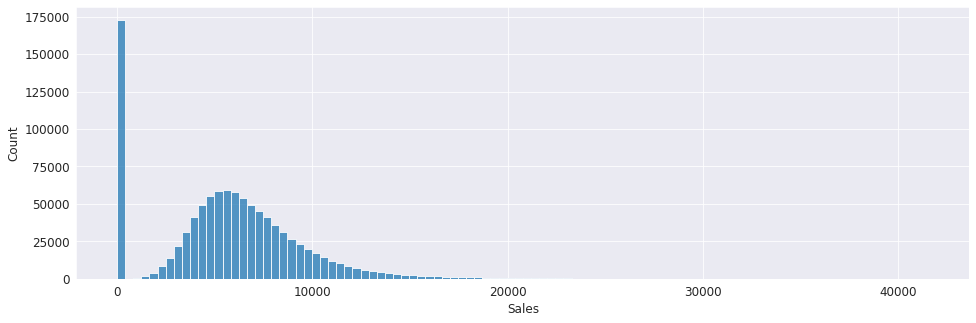

In [ ]:
# graph: target variable (Sales) distribution
plt.figure(figsize = (16, 5))
sns.histplot(data = df1, x = 'Sales', bins = 100)
axis_settings('Sales', 'Count')

**Observation:**
- There are a lot of days with zero sales;
- It's a right skewed variable and would need some data transformation to treat its skewness.

## 3. DATA CLEANING

In [6]:
df2 = df1.copy()

### 3.1. `Date`
Approach: change attribute type (object -> datetime).

In [8]:
df2['Date'] = pd.to_datetime(df1['Date'])

### 3.2. `CompetitionDistance`
Approach: replaces NA values with a very large value.

In [9]:
df2['CompetitionDistance'] = df2['CompetitionDistance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

### 3.3. `CompetitionOpenSinceMonth`
Approach: replaces the missing month with the month contained in the `Date` attribute.

In [10]:
df2['CompetitionOpenSinceMonth'] = df2.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth']) else
                                                       x['CompetitionOpenSinceMonth'], 
                                             axis = 1)

### 3.4. `CompetitionOpenSinceYear`
Approach: replaces the missing year with the year contained in the `Date` attribute.

In [11]:
df2['CompetitionOpenSinceYear'] = df2.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear']) else
                                                      x['CompetitionOpenSinceYear'], 
                                            axis = 1)

### 3.5. `Promo2SinceWeek`
Approach: replaces the missing week with the week contained in the `Date` attribute.

In [12]:
df2['Promo2SinceWeek'] = df2.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek']) else 
                                             x['Promo2SinceWeek'], 
                                   axis = 1)

### 3.6. `Promo2SinceYear`
Approach: replaces the missing year with the year contained in the `Date` attribute.

In [13]:
df2['Promo2SinceYear'] = df2.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear']) else 
                                             x['Promo2SinceYear'], 
                                   axis = 1)

### 3.7. `PromoInterval`
Approach: replaces NA values with zero and creates a variable called `IsPromo` that tells whether promotion 2 is taking place or not.

In [14]:
# dictionary that stores a code (number) for each month
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  
             7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

# replaces NA values with zero
df2['PromoInterval'].fillna(0, inplace = True)

# creates a variable called `MonthMap` that contains the month (from the attribute `Date`) in numeric format
df2['MonthMap'] = df2['Date'].dt.month.map(month_map)

# creates a variable called `IsPromo` that shows if promotion 2 is taking place in the current month 
df2['IsPromo'] = df2[['PromoInterval', 'MonthMap']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 
                                                                    1 if x['MonthMap'] in x['PromoInterval'].split(',') else 
                                                                    0, 
                                                          axis = 1)

### 3.8. Change data types

In [15]:
# float -> int
df2['CompetitionOpenSinceMonth'] = df2['CompetitionOpenSinceMonth'].astype(int)
df2['CompetitionOpenSinceYear'] = df2['CompetitionOpenSinceYear'].astype(int)
df2['Promo2SinceWeek'] = df2['Promo2SinceWeek'].astype(int)
df2['Promo2SinceYear'] = df2['Promo2SinceYear'].astype(int)

## 4. FEATURE ENGINEERING

In [16]:
# copy
df3 = df2.copy()

### 4.1. Extracting features from the `Date` variable

In [17]:
# year
df3['Year'] = df3['Date'].dt.year

# month
df3['Month'] = df3['Date'].dt.month

# day
df3['Day'] = df3['Date'].dt.day

# week of year
df3['WeekOfYear'] = df3['Date'].dt.isocalendar().week

# year week
df3['YearWeek'] = df3['Date'].dt.strftime('%Y-%W')

### 4.2. `CompetitionSince`

In [18]:
df3['CompetitionSince'] = df3.apply(lambda x: datetime.datetime(year = x['CompetitionOpenSinceYear'], 
                                                                month = x['CompetitionOpenSinceMonth'], day = 1), 
                                    axis = 1)

df3['CompetitionTimeMonth'] = ((df3['Date'] - df3['CompetitionSince']) / 30).apply(lambda x: x.days).astype(int)

### 4.3. `PromoSince`

In [19]:
df3['PromoSince'] = df3['Promo2SinceYear'].astype(str) + '-' + df3['Promo2SinceWeek'].astype(str)
df3['PromoSince'] = df3['PromoSince'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df3['PromoTimeWeek'] = ((df3['Date'] - df3['PromoSince']) / 7).apply(lambda x: x. days).astype(int)

### 4.4. `Assortment`

In [20]:
df3['Assortment'] = df3['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

### 4.5. `StateHoliday`

In [21]:
df3['StateHoliday'] = df3['StateHoliday'].apply(lambda x: 'Public holiday' if x == 'a' else 
                                                          'Easter holiday' if x == 'b' else 
                                                          'Christmas'      if x == 'c' else 
                                                          'Regular day')

### 4.6. Variable filtering

#### 4.6.1. Row filtering

In [22]:
df3 = df3[(df3['Open'] != 0) & (df3['Sales'] > 0)]

#### 4.6.2. Column filtering

In [23]:
drop_columns = ['Customers' , 'Open' , 'PromoInterval', 'MonthMap']
df3 = df3.drop(drop_columns, axis = 1)

## 5. EXPLORATORY DATA ANALYSIS

In [24]:
# copy
df4 = df3.copy()

### 5.1. Hypothesis mind map

![](https://drive.google.com/uc?export=view&id=1IZHUV9ixmip4dy4HK6Cvb0_PVOkKn8mr)

### 5.2. Hypothesis

#### 5.2.1. Stores with larger assortments should sell more.
Conclusion: **true** hypothesis

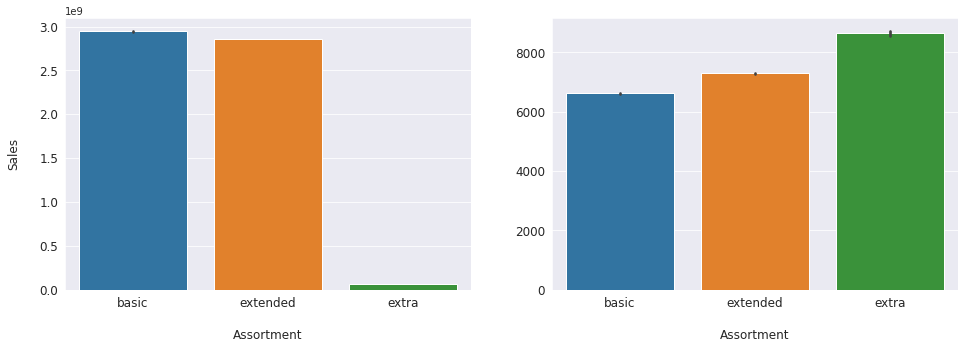

In [ ]:
plt.figure(figsize = (16, 5))

# graph 1: Total Sales by Assortment
plt.subplot(1, 2, 1)
sns.barplot(x = 'Assortment', y = 'Sales', data = df4, estimator = np.sum)
axis_settings('\nAssortment', 'Sales\n')

# graph 2: Average Sales by Assortment
plt.subplot(1, 2, 2)
sns.barplot(x = 'Assortment', y = 'Sales', data = df4, estimator = np.mean)
axis_settings('\nAssortment')

plt.show()

In [ ]:
# quantity of each type of assortment
aux = df4.groupby('Store').agg(pd.Series.mode).reset_index()
aux['Assortment'].value_counts()

basic       593
extended    513
extra         9
Name: Assortment, dtype: int64

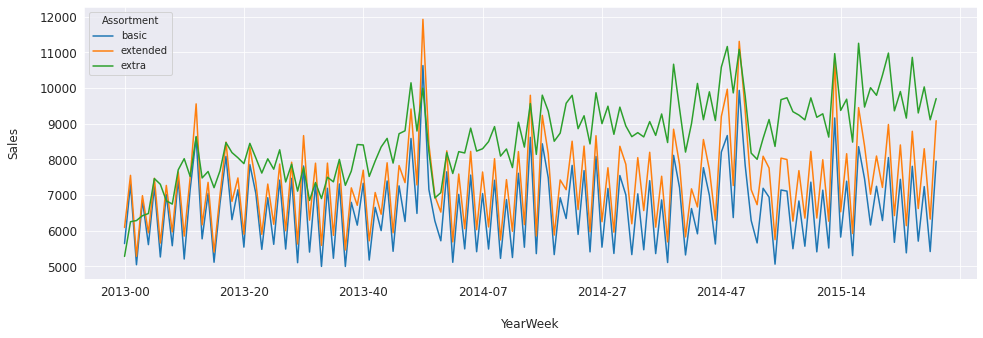

In [ ]:
# graph 3: average sales over time
aux = df4[['YearWeek', 'Assortment', 'Sales']].groupby(['YearWeek', 'Assortment']).mean().reset_index()
aux.pivot(index = 'YearWeek', columns = 'Assortment', values = 'Sales').plot(figsize = (16, 5))
axis_settings('\nYearWeek', 'Sales\n')

**Observations:**
- I assumed that `basic` < `extended` < `extra`;
- Graph 1 shows the total amount of sales by type of assortment, and it is possible to notice that stores with a greater assortment have a much lower sales volume than the others. Analyzing which stores have each type of assortment, we see that the `extra` assortment is present in only 9 of the 1115 mapped stores, so this graph would not be ideal to validate this hypothesis.
- Graph 2 shows the average amount of sales by type of assortment. In it, it is possible to notice a behavior very different from that of graph 1, showing an increase in the average amount of sales as the assortment increases. 
- Graph 3 shows the average amount of sales over time, highlighting each type of assortment. It is possible to see that stores with an `extra` assortment are superior to the others in most of the analyzed period.

#### 5.2.2. Stores with closer competitors should sell less.
Conclusion: **false** hypothesis

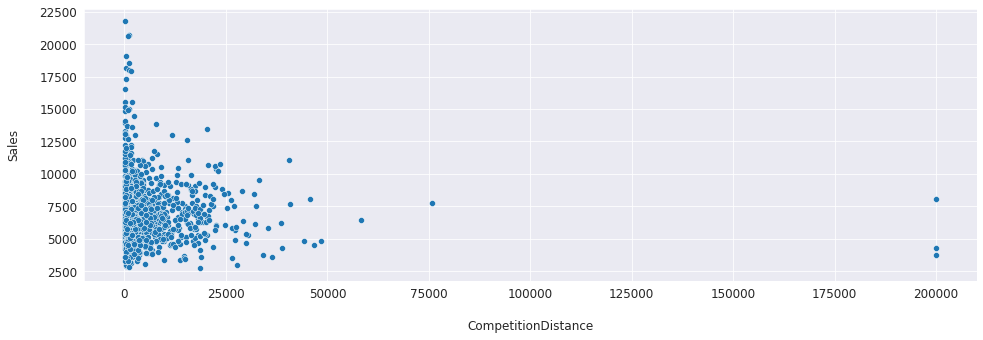

In [ ]:
aux = df4[['Store', 'CompetitionDistance', 'Sales']].groupby('Store').mean().reset_index()

# graph 1: Average Sales by CompetitionDistance
plt.figure(figsize = (16, 5))
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = aux)
axis_settings('\nCompetitionDistance', 'Sales\n')

plt.show()

In [ ]:
# correlation between `CompetitionDistance` and `Sales`
aux[['CompetitionDistance', 'Sales']].corr()

,CompetitionDistance,Sales
CompetitionDistance,1.000000,-0.052859
Sales,-0.052859,1.000000


**Observations:**
- the graph shows the average amount of sales for each store by the distances each store has from the nearest competitor. From this it is possible to see that most stores sell more the closer the competitors are;
- this variable has a low correlation with the target variable `Sales`.

#### 5.2.3. Stores with longer competitors should sell more.
Conclusion: **true** hypothesis

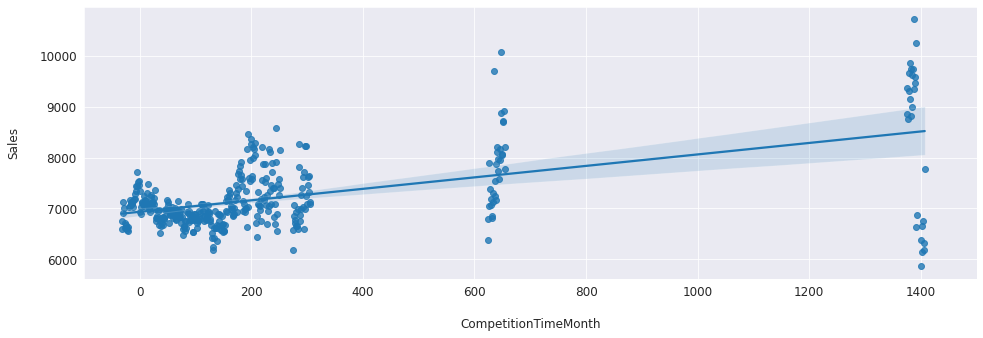

In [ ]:
aux = df4[['CompetitionTimeMonth', 'Sales']].groupby('CompetitionTimeMonth').mean().reset_index()

# graph 1: Average Sales by CompetitionTimeMonth
plt.figure(figsize = (16, 5))
sns.regplot(x = 'CompetitionTimeMonth', y = 'Sales', data = aux)
axis_settings('\nCompetitionTimeMonth', 'Sales\n')
plt.xlim(-100, 1500)

plt.show()

**Observations:**
- the graph above shows that the longer a competitor is established, the greater the amount of sales (on average).

#### 5.2.4. Stores with longer active promotions should sell more.
Conclusion: **false** hypothesis

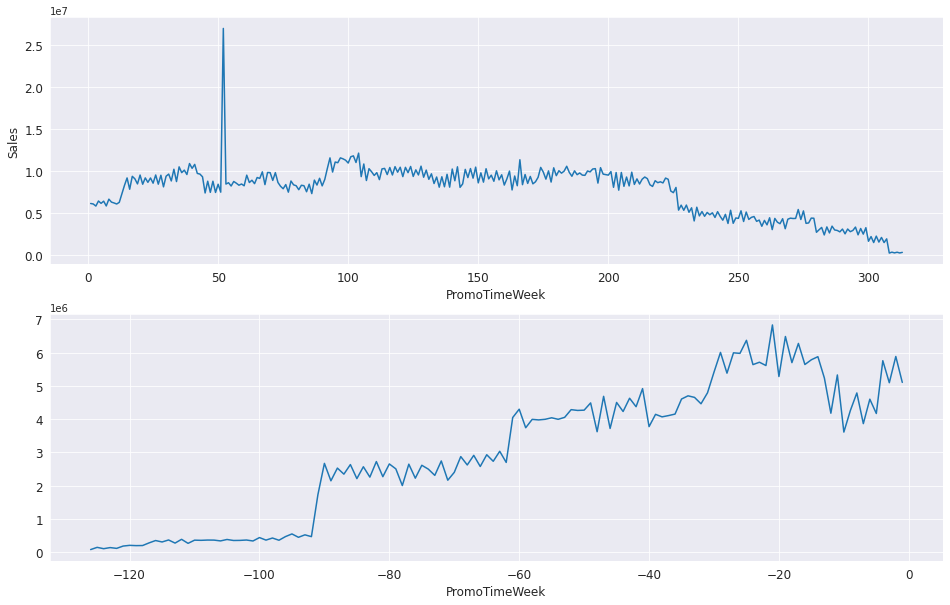

In [ ]:
aux1 = df4[['PromoTimeWeek', 'Sales']].groupby('PromoTimeWeek').sum().reset_index()

plt.figure(figsize = (16, 10))

# graph 1: extended promotion
plt.subplot(2, 1, 1)
aux2 = aux1[aux1['PromoTimeWeek'] > 0]
sns.lineplot(x = 'PromoTimeWeek', y = 'Sales', data = aux2)
axis_settings('PromoTimeWeek', y_label = 'Sales')

# graph 2: regular promotion
plt.subplot(2, 1, 2)
aux3 = aux1[aux1['PromoTimeWeek'] < 0]
sns.lineplot(x = 'PromoTimeWeek', y = 'Sales', data = aux3)
axis_settings('PromoTimeWeek')

plt.show()

**Observations:**
- graph 1 shows the period of sales after the start of the extended promotion. It is possible to notice that as time passes, the effect that the promotion has on sales decreases;
- graph 2 shows the sales period before the start of the extended promotion. It is possible to notice that as the days approach the beginning of the promotion, sales increase.

#### 5.2.5. Stores with more consecutive promotions should sell more.
Conclusion: **false** hypothesis

In [ ]:
# table 1: sales grouped by type of pomotion
df4[['Promo', 'Promo2', 'Sales']].groupby(['Promo', 'Promo2']).sum().reset_index()

,Promo,Promo2,Sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


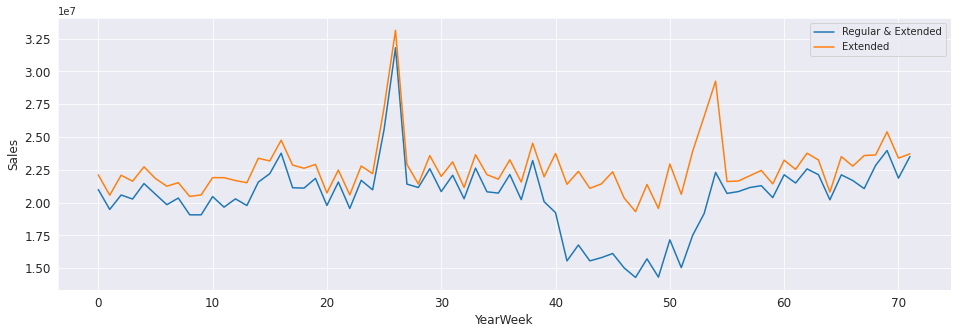

In [ ]:
# graph 1: sales by YearWeek
aux1 = df4[(df4['Promo'] == 1) & (df4['Promo2'] == 1)][['YearWeek', 'Sales']].groupby('YearWeek').sum().reset_index()
ax = aux1.plot(figsize = (16, 5))

aux2 = df4[(df4['Promo'] == 1) & (df4['Promo2'] == 0)][['YearWeek', 'Sales']].groupby('YearWeek').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Regular & Extended', 'Extended'])
axis_settings('YearWeek', 'Sales')

plt.show()

**Observations:**
- table 1 shows that the biggest sales happened when the store participated only regular promotion;
- table 1 shows that the lower sales happened when the store participated only extended promotion;
- in graph 1 we can see the behavior of sales in stores with only extended promotion and in stores with both promotions. It is possible to observe that the stores that participated in both promotions have a similar behavior to the stores that participated only in the extended promotion, but with a smaller quantity.

#### 5.2.6. Stores open during the Christmas holiday should sell more.
Conclusion: **false** hypothesis

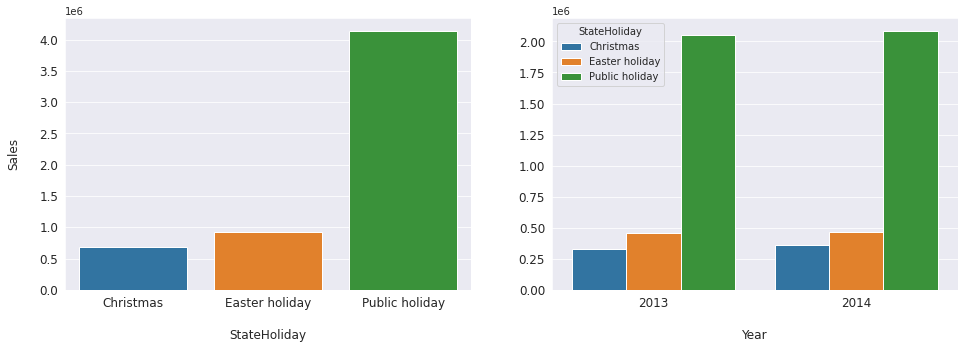

In [ ]:
# there are more regular day than holidays
# the records go to july 2015
aux = df4[(df4['StateHoliday'] != 'Regular day') & (df4['Date'] < '2015-01-01')]

plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
aux1 = aux[['StateHoliday', 'Sales']].groupby('StateHoliday').sum().reset_index()
sns.barplot(x = 'StateHoliday', y = 'Sales', data = aux1)
axis_settings('\nStateHoliday', 'Sales\n')

plt.subplot(1, 2, 2)
aux2 = aux[['Year', 'StateHoliday', 'Sales']].groupby(['Year', 'StateHoliday']).sum().reset_index()
sns.barplot(x = 'Year', y = 'Sales', hue = 'StateHoliday', data = aux2)
axis_settings('\nYear', ' ')

**Observations:**
- the graphs only show the records up to January 2015, as the year 2015 is incomplete;
- in both graphs, the Christmas holiday has a lower total sales.

#### 5.2.7. Stores should sell more over the years.
Conclusion: **true** hypothesis

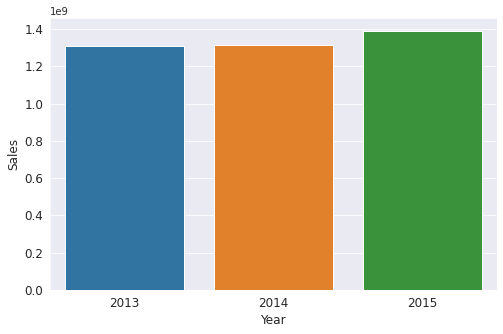

In [ ]:
aux = df4[(df4['Month'] >= 1) & (df4['Month'] <= 7)]
aux1 = aux[['Year', 'Sales']].groupby('Year').sum().reset_index()

plt.figure(figsize = (8, 5))
sns.barplot(x = 'Year', y = 'Sales', data = aux1)
axis_settings('Year', 'Sales')

plt.show()

**Observations:**
- the data was collected between 01/01/2013 to 07/31/2015, so the year 2015 is incomplete. To compare the amount of sales of the years, I decided to use data between January to July of each year;
- there is a small growth in the amount of sales over the years, according to the period analyzed.

#### 5.2.8. Stores should sell more in the second half of the year.
Conclusion: **false** hypothesis

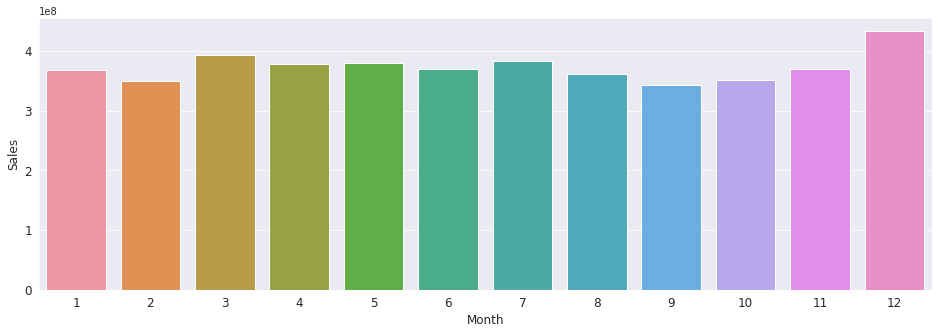

In [ ]:
aux = df4[df4['Date'] <= '2015-01-01']
aux1 = aux[['Month', 'Sales']].groupby('Month').sum().reset_index()

plt.figure(figsize = (16, 5))
sns.barplot(x = 'Month', y = 'Sales', data = aux1)
axis_settings('Month', 'Sales')

plt.show()

**Observations:**
- I used the data until 01/01/2015;
- the amount of sales does not vary much over the months.

#### 5.2.9. Stores should sell more after the 15th of each month.
Conclusion: **true** hypothesis

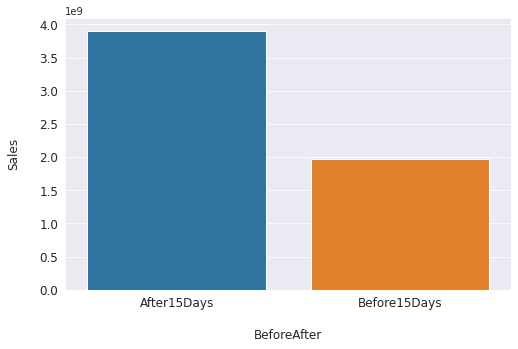

In [ ]:
aux1 = df4[['Day', 'Sales']].groupby('Day').sum().reset_index()
aux1['BeforeAfter'] = aux1['Day'].apply(lambda x: 'Before15Days' if x <= 10 else 'After15Days')
aux2 = aux1[['BeforeAfter', 'Sales']].groupby('BeforeAfter').sum().reset_index()

plt.figure(figsize = (8, 5))
sns.barplot(x = 'BeforeAfter', y = 'Sales', data = aux2)
axis_settings('\nBeforeAfter', 'Sales\n')

plt.show()

**Observation:**
- stores sell more in the first half of the month.

#### 5.2.10. Stores should sell less on weekends.
Conclusion: **true** hypothesis

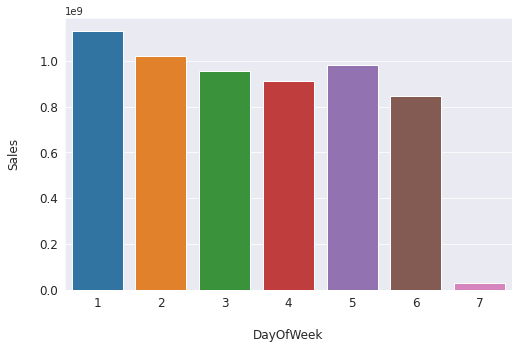

In [ ]:
aux1 = df4[['DayOfWeek', 'Sales']].groupby('DayOfWeek').sum().reset_index()

plt.figure(figsize = (8, 5))

sns.barplot(x = 'DayOfWeek', y = 'Sales', data = aux1)
axis_settings('\nDayOfWeek', 'Sales\n')

plt.show()

**Observations:**
- the days 6 (Saturday) and 7 (Sunday) the amount of sales is lower than weekdays.

#### 5.2.11. Stores should sell less during school holidays.
Conclusion: **true** hypothesis

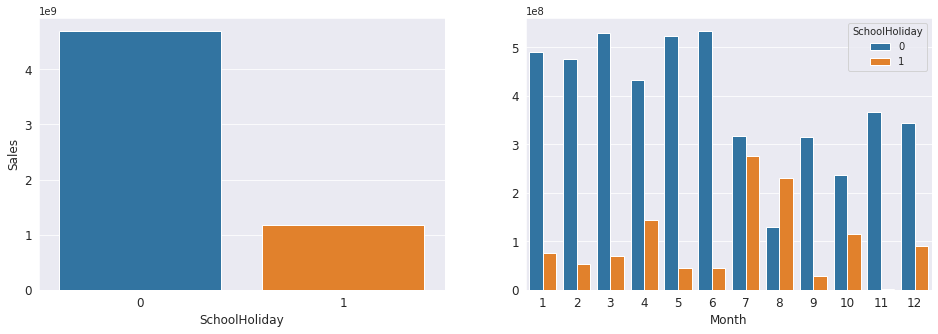

In [ ]:
aux1 = df4[['SchoolHoliday', 'Sales']].groupby('SchoolHoliday').sum().reset_index()
aux2 = df4[['Month', 'SchoolHoliday', 'Sales']].groupby(['Month','SchoolHoliday']).sum().reset_index()

plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x = 'SchoolHoliday', y = 'Sales', data = aux1)
axis_settings('SchoolHoliday', 'Sales')


plt.subplot(1, 2, 2)
sns.barplot(x = 'Month', y = 'Sales', hue = 'SchoolHoliday', data = aux2)
axis_settings('Month')

plt.show()

**Observations:**
- in the first graph it is possible to see that sales are lower on school holidays;
- the second graph shows that this pattern is repeated in almost every month except August. In July, the difference between the two categories is much smaller than in other months.

## 6. DATA PREPARATION

In [25]:
# copy
df5 = df4.copy()

### 6.1. Rescaling

In [26]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['CompetitionDistance'] = rs.fit_transform(df5[['CompetitionDistance']].values)
pickle.dump(rs, open('webapp/parameter/competition_distance_scaler.pkl', 'wb'))


# competition time month
df5['CompetitionTimeMonth'] = rs.fit_transform(df5[['CompetitionTimeMonth']].values)
pickle.dump(rs, open('webapp/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['PromoTimeWeek'] = mms.fit_transform(df5[['PromoTimeWeek']].values)
pickle.dump(rs, open('webapp/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['Year'] = mms.fit_transform(df5[['Year']].values)
pickle.dump(mms, open('webapp/parameter/year_scaler.pkl', 'wb'))

### 6.2. Encoding

In [27]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['StateHoliday'], columns = ['StateHoliday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['StoreType'] = le.fit_transform(df5['StoreType'])
pickle.dump(le, open('webapp/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['Assortment'] = df5['Assortment'].map(assortment_dict)

### 6.3. Response Variable Transformation

In [28]:
df5['Sales'] = np.log1p(df5['Sales'])

 ### 6.4. Nature Transformation

In [29]:
# day of week
df5['DayOfWeekSin'] = df5['DayOfWeek'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['DayOfWeekCos'] = df5['DayOfWeek'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
df5['MonthSin'] = df5['Month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['MonthCos'] = df5['Month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
df5['DaySin'] = df5['Day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['DayCos'] = df5['Day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week of year
df5['WeekOfYearSin'] = df5['WeekOfYear'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['WeekOfYearCos'] = df5['WeekOfYear'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

## 7. FEATURE SELECTION

In [30]:
# copy
df6 = df5.copy()

### 7.1. Split dataframe into training and test dataset

In [31]:
# drop some variables
drop_columns = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'PromoSince', 'CompetitionSince', 'YearWeek']
df6 = df6.drop(drop_columns, axis = 1)

In [32]:
# training dataset
x_train = df6[df6['Date'] < '2015-06-19']
y_train = x_train['Sales']

# test dataset
x_test = df6[df6['Date'] >= '2015-06-19']
y_test = x_test['Sales']

print('Training Min Date: {}'.format(x_train['Date'].min()))
print('Training Max Date: {}'.format(x_train['Date'].max()))

print('\nTest Min Date: {}'.format(x_test['Date'].min()))
print('Test Max Date: {}'.format(x_test['Date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 7.2. Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
x_train_n = x_train.drop(['Date', 'Sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [ ]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['Date', 'Sales'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

### 7.3. Manual Feature Selection

In [33]:
cols_selected_boruta = ['Store', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionTimeMonth',
                        'PromoTimeWeek', 'DayOfWeekSin', 'DayOfWeekCos', 'MonthSin', 'MonthCos', 'DaySin', 'DayCos',
                        'WeekOfYearSin', 'WeekOfYearCos']

# columns to add
feat_to_add = ['Date', 'Sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 8. MODEL BUILDING

In [34]:
x_train2 = x_train[cols_selected_boruta]
x_test2 = x_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = x_train[cols_selected_boruta_full]

### 8.1. Average Model

In [ ]:
aux1 = x_test2.copy()
aux1['Sales'] = y_test.copy()

# prediction
aux2 = aux1[['Store', 'Sales']].groupby('Store').mean().reset_index().rename(columns = {'Sales': 'Predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'Store')
yhat_baseline = aux1['Predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.8004,0.2064,1835.1355


### 8.2. Linear Regression Model

#### 8.2.1. Hold-out method

In [ ]:
# model
lr = LinearRegression().fit(x_train2, y_train)

# prediction
yhat_lr = lr.predict(x_test2) 

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.0898,0.2927,2671.0492


#### 8.2.2. K-fold cross validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.7272 +/- 295.6259,0.3026 +/- 0.0166,2952.5208 +/- 468.3704


### 8.3. Linear Regression Regularized Model (Lasso)

#### 8.3.1. Hold-out method

In [ ]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train2, y_train)

# prediction
yhat_lrr = lrr.predict(x_test2)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517


#### 8.3.2. K-fold cross validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.3816 +/- 341.5014,0.292 +/- 0.0118,3057.7495 +/- 504.2612


### 8.4. Random Forest Regressor

#### 8.4.1. Hold-out method

In [ ]:
# model
rf = RandomForestRegressor(n_estimators = 100, random_state = 42).fit(x_train2, y_train)

# prediction
yhat_rf = rf.predict(x_test2)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.0805,0.0999,1010.1017


#### 8.4.2. K-fold cross validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7043 +/- 219.2377,0.1161 +/- 0.0232,1256.5934 +/- 320.278


### 8.5. XGBoost Regressor

#### 8.5.1. Hold-out method

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7).fit(x_train2, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test2)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.1123,0.1226,1250.9526


#### 8.5.2. K-fold cross validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.2788 +/- 167.1926,0.1441 +/- 0.0182,1478.2595 +/- 229.7945


### 8.5. Comparison between models

#### 8.5.1. Hold-out method

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.0805,0.0999,1010.1017
0,XGBoost Regressor,843.1123,0.1226,1250.9526
0,Average Model,1354.8004,0.2064,1835.1355
0,Linear Regression,1867.0898,0.2927,2671.0492
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517


**Observations:**
- the Random Forest Regressor model misses less, as shown in the table above, followed by the XGBoost Regressor;
- XGBoost will be chosen, even though it is not the best model, as it has a much shorter execution time than Random Forest.

#### 8.5.2. K-fold cross validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.7272 +/- 295.6259,0.3026 +/- 0.0166,2952.5208 +/- 468.3704
0,Lasso,2116.3816 +/- 341.5014,0.292 +/- 0.0118,3057.7495 +/- 504.2612
0,Random Forest Regressor,837.7043 +/- 219.2377,0.1161 +/- 0.0232,1256.5934 +/- 320.278
0,XGBoost Regressor,1030.2788 +/- 167.1926,0.1441 +/- 0.0182,1478.2595 +/- 229.7945


### 8.6. Final model

In [38]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = 100,
                                   eta = 0.01,
                                   max_depth = 10,
                                   subsample = 0.7).fit(x_train2, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test2)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

In [39]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.1123,0.1226,1250.9526


In [40]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.009945518649641345

**Observations:**
- the value of `mpe` shows that the model is overestimated, that is, it predicts values greater than the actual value.

In [41]:
# save the model
pickle.dump(model_xgb_tuned, open('/content/drive/MyDrive/ANA/rossmann/model/model_rossmann.pkl', 'wb') )

## 9. TRANSLATION AND INTERPRETATION OF ERROR

In [42]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['Sales'] = np.expm1(df9['Sales'])
df9['Predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1. Business performance

In [43]:
# sum of predictions
df91 = df9[['Store', 'Predictions']].groupby('Store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['Store', 'Sales', 'Predictions']].groupby('Store').apply(lambda x: mean_absolute_error(x['Sales'], x['Predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['Store', 'Sales', 'Predictions']].groupby('Store').apply(lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'Store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'Store')

# Scenarios
df92['WorstScenario'] = df92['Predictions'] - df92['MAE']
df92['BestScenario'] = df92['Predictions'] + df92['MAE']

# order columns
df92 = df92[['Store', 'Predictions', 'WorstScenario', 'BestScenario', 'MAE', 'MAPE']]

In [44]:
df92.sort_values('MAPE', ascending = False).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
291,292,112511.804688,108997.113256,116026.496119,3514.691432,0.642664
908,909,209823.796875,201637.830906,218009.762844,8185.965969,0.530038
285,286,192566.843750,191050.091368,194083.596132,1516.752382,0.507219
487,488,200171.265625,198498.177464,201844.353786,1673.088161,0.462820
594,595,293021.843750,286638.298986,299405.388514,6383.544764,0.436529


**Observations:**
- the table above shows that there are stores that are difficult to predict sales, in the next CRISP cycle, new strategies will be implemented to try to deal with these stores.

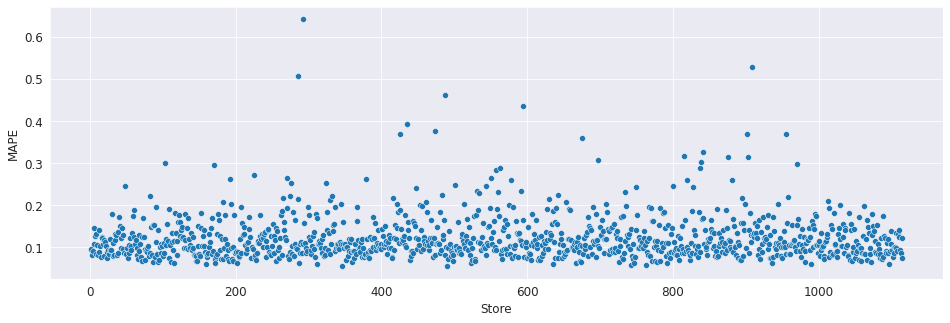

In [45]:
plt.figure(figsize = (16, 5))

sns.scatterplot(x = 'Store', y = 'MAPE', data = df92)
axis_settings('Store', 'MAPE')

plt.show()

**Observations:**
- the graphic above shows that the most of stores have `MAPE` values less than 0.2 (20%);
- there are stores with error bigger than 0.5 (50%), as it shown in the table.

### 9.2. Total performance

In [46]:
df93 = df92[['Predictions', 'WorstScenario', 'BestScenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'. format)
df93

,Scenario,Values
0,Predictions,"R$281,029,504.00"
1,WorstScenario,"R$280,086,794.85"
2,BestScenario,"R$281,972,222.57"


### 9.3. Machine learning performance

In [47]:
df9['Error'] = df9['Sales'] - df9['Predictions']
df9['ErrorRate'] = df9['Predictions'] / df9['Sales']

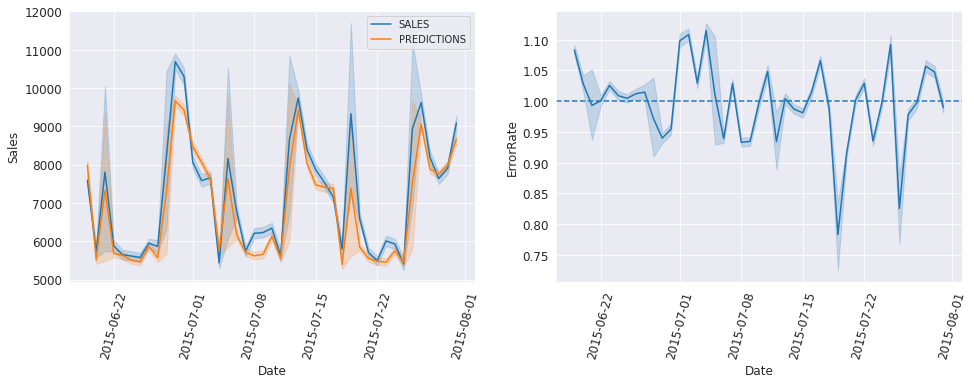

In [48]:
plt.figure(figsize = (16, 5))

# graph 1: Sales by Date
plt.subplot(1, 2, 1)
sns.lineplot(x = 'Date', y = 'Sales', data = df9, label = 'SALES')
sns.lineplot(x = 'Date', y = 'Predictions', data = df9, label = 'PREDICTIONS')
axis_settings('Date', 'Sales', x_rotation = 75)

# graph 2: Error rate by Date
plt.subplot(1, 2, 2)
sns.lineplot(x = 'Date', y = 'ErrorRate', data = df9)
plt.axhline(1, linestyle = '--')
axis_settings('Date', 'ErrorRate', x_rotation = 75)

plt.show()

**Observations:**
- graph 1 shows the value of actual and predicted sales by the model over the weeks;
- graph 2 shows the error rate over time. The dashed line at y = 1 shows that values above it correspond to periods in which the model overestimates sales, and below it the model underestimates it.

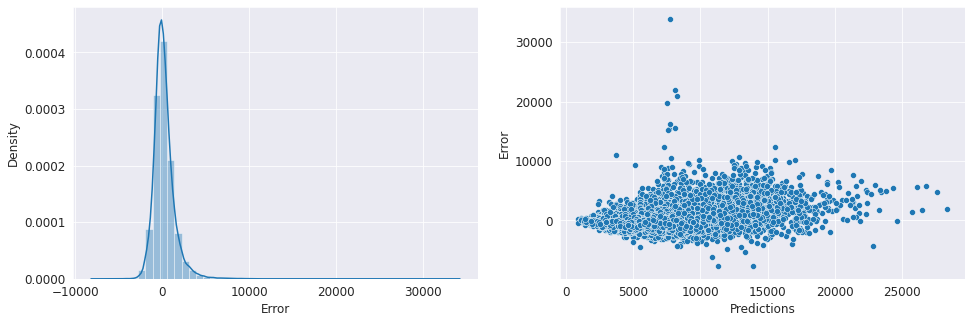

In [50]:
plt.figure(figsize = (16, 5))

# graph 3: Error distribuition
plt.subplot(1, 2, 1)
sns.distplot(df9['Error'])
axis_settings('Error', 'Density')

# graph 4: Error by Predictions
plt.subplot(1, 2, 2)
sns.scatterplot(data = df9, x = 'Predictions', y = 'Error')
axis_settings('Predictions', 'Error')

plt.show()

**Observations:**
- Graph 3 shows that the errors have a distribution close to normal;
- Graph 4 shows that there are some residuals that were not adequately predicted by the model, and that the residuals are randomly dispersed around zero, it indicates the expected behavior for the distribution of errors.